In [1]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, f1_score
from torchcrf import CRF
from utils import get_sequences, GetLabels, My_Pad_Input, GetImgAndTextEmbs, GetMissingImage, GetMissingText, GetImgEmbs, GetTextEmbs

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [3]:
torch.cuda.set_device(1)

In [4]:
torch.cuda.current_device()

1

In [5]:
OUT_DIM=12
INPUT_DIM=128
BS= 8

In [6]:
train = pd.read_csv("./data/train_fusion.csv")
val = pd.read_csv("./data/val_fusion.csv")
test_data = pd.read_csv("./data/test_fusion.csv")

In [7]:
train["document_type"] = train.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                     axis=1)
val["document_type"] = val.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                     axis=1)
test_data["document_type"] = test_data.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                   axis=1)

In [8]:
X_train, y_train = get_sequences(train)
X_valid, y_valid = get_sequences(val)
X_test, y_test = get_sequences(test_data)

In [9]:
data = pd.concat([pd.DataFrame({"acts":X_train, "labels":y_train, "is_valid": False}),
                 pd.DataFrame({"acts":X_valid, "labels":y_valid, "is_valid": True})])

In [10]:
data.head()

,acts,labels,is_valid
0,"[activations/text/train/outros/AI_856934_1926210_1060_17072013_1, activations/text/train/outros/AI_856934_1926211_34_17072013_1, activations/text/train/outros/AI_856934_1926211_34_17072013_2, activations/text/train/outros/AI_856934_1926211_34_17072013_3, activations/text/train/outros/AI_856934_1926211_34_17072013_4, activations/text/train/outros/AI_856934_1926211_34_17072013_5, activations/text/train/outros/AI_856934_1926211_34_17072013_6, activations/text/train/outros/AI_856934_1926211_34_17072013_7, activations/text/train/outros/AI_856934_1926211_34_17072013_8, activations/text/train/out...","[B-outros, B-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, B-outros, I-outros, I-outros, I-outros, B-sentenca, I-sentenca, I-sentenca, I-sentenca, I-sentenca, B-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, B-outros, I-outros, I-outros, I-outros, B-despacho_de_admissibilidade, B-outros]",False
1,"[activations/text/train/outros/AI_857179_2056961_27_22072013_1, activations/text/train/outros/AI_857179_2056961_27_22072013_2, activations/text/train/outros/AI_857179_2056961_27_22072013_3, activations/text/train/outros/AI_857179_2056961_27_22072013_4, activations/text/train/outros/AI_857179_2056961_27_22072013_5, activations/text/train/outros/AI_857179_2056961_27_22072013_6, activations/text/train/outros/AI_857179_2056961_27_22072013_7, activations/text/train/outros/AI_857179_2056961_27_22072013_8, activations/text/train/outros/AI_857179_2056961_27_22072013_9, activations/text/train/outro...","[B-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, B-outros, B-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, B-sentenca, I-sentenca, I-sentenca, I-sentenca, I-sentenca, B-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, B-outros, B-outros, I-outros, I-outros, B-acordao_de_2_instancia, B-outros, B-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_RE, I-peticao_do_R...",False
2,"[activations/text/train/outros/AI_858252_2476190_26_05082013_1, activations/text/train/outros/AI_858252_2476190_26_05082013_2, activations/text/train/outros/AI_858252_2476190_26_05082013_3, activations/text/train/outros/AI_858252_2476190_26_05082013_4, activations/text/train/outros/AI_858252_2476190_26_05082013_5, activations/text/train/outros/AI_858252_2476190_26_05082013_6, activations/text/train/outros/AI_858252_2476190_26_05082013_7, activations/text/train/outros/AI_858252_2476190_26_05082013_8, activations/text/train/outros/AI_858252_2476190_26_05082013_9, activations/text/train/outro...","[B-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, B-outros, B-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, B-outros, I-outros, I-outros, B-outros, I-outros, B-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, I-outros, B-outros, B-outros, B-outros, B-outros, I-outros, B-outros, B-outros]",False
3,"[activations/text/train/outros/AI_866251_311097804_95_24012017_1, activations/text/train/outros/AI_866251_311097804_95_24012017_2, activations/text/train/outros/AI_866251_311097806_95_24012017_1, activations/text/train/outros/AI_866251_311097806_95_24012017_2, activations/text/train/outros/AI_866251_311262256_1060_01032017_1]","[B-outros, I-outros, B-outros, I-outros, B-outros]",False
4,"[activations/text/train/outros/AI_866877_311791866_1280_11052017_1, activations/text/train/outros/AI_866877_311811769_95_1605

In [11]:
my_pad_input=My_Pad_Input(12, from_embs=True)

In [13]:
tfms = [[GetImgEmbs()], [GetTextEmbs()], [GetMissingImage()], [GetMissingText()], [GetLabels()]]
splits = ColSplitter()(data)
dsets = Datasets(data, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=partial(my_pad_input, pad_fields=[0,1,2,3,4]), bs=BS)

In [14]:
torch.save(dls, "./data/dls_sequence_from_embs_v3.pth")

In [12]:
dls = torch.load("./data/dls_sequence_from_embs_v3.pth")

In [13]:
class LSTMModel(Module):
    def __init__(self, input_dim, out_dim, hidden_dim=128, img_emb_dim=4096, text_emb_dim=3840):
        self.img_none_emb = torch.nn.Embedding(num_embeddings=1, embedding_dim=img_emb_dim).cuda()
        self.text_none_emb = torch.nn.Embedding(num_embeddings=1, embedding_dim=text_emb_dim).cuda()
        self.index= tensor(0).cuda()
        self.lstm = torch.nn.LSTM(input_size=hidden_dim*4, hidden_size=hidden_dim,
                                  batch_first=True, bidirectional=True).cuda()
        self.bn1 = nn.BatchNorm1d(input_dim, momentum=0.01).cuda()
        self.bn2 = nn.BatchNorm1d(hidden_dim*2, momentum=0.01).cuda()
        self.drop1 = nn.Dropout().cuda()
        self.drop2 = nn.Dropout().cuda()
        self.lin1 = nn.Linear(input_dim, hidden_dim*4).cuda()
        self.lin2 = nn.Linear(hidden_dim*2, out_dim).cuda()
        self.relu = nn.ReLU().cuda()
        
    def forward(self, img_act, text_act, img_none, text_none):
        img_act[img_none==1] = self.img_none_emb(self.index)
        text_act[text_none==1] = self.text_none_emb(self.index)
        x = torch.cat([img_act, text_act], axis=-1)
        x = x.permute(0, 2, 1)
        x = self.bn1(x)
        x = self.drop1(x)
        x = x.permute(0, 2, 1)
        x = self.lin1(x)
        x = self.relu(x)
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out_norm = self.bn2(out)
        out_drop = self.drop2(out_norm)
        out_drop = out_drop.permute(0, 2, 1)
        return self.lin2(out_drop)

In [194]:
model = LSTMModel(7936, 12)

In [14]:
def loss_func(out, targ):
    return CrossEntropyLossFlat(ignore_index=OUT_DIM)(out, targ.long())

In [15]:
def _accumulate(self, learn):
    pred = learn.pred
    targ = learn.y
    pred,targ = to_detach(pred),to_detach(targ)
    pred =np.argmax(pred, axis=-1)
    pred, targ = flatten_check(pred, targ)
    pad_idxs = [i for i,x in enumerate(targ) if x != tensor([12])]
    pred = pred[pad_idxs]
    targ = targ[pad_idxs]
    pred = torch.remainder(pred, 6)
    targ = torch.remainder(targ, 6)
    self.preds.append(pred)
    self.targs.append(targ)

AccumMetric.accumulate = _accumulate

def MyFScore(average='macro'):
    return skm_to_fastai(f1_score, average=average)

In [16]:
dls.bs = dls.train.bs = dls.valid.bs = 8

In [198]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [199]:
learn.summary()

LSTMModel (Input shape: ['8 x 4242 x 4096', '8 x 4242 x 3840', '8 x 4242', '8 x 4242'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            8                    4,096      True      
________________________________________________________________
Embedding            8                    3,840      True      
________________________________________________________________
LSTM                 ['8 x 4242 x 256',   657,408    True      
________________________________________________________________
BatchNorm1d          8 x 7936 x 4242      15,872     True      
________________________________________________________________
BatchNorm1d          8 x 256 x 4242       512        True      
________________________________________________________________
Dropout              8 x 7936 x 4242      0          False     
________________________________________________________________
Dropout              8 x 256 x 4242       0          False     
__________

In [200]:
learn.validate()

(#2) [2.5355186462402344,0.02303478949042298]

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.00015848931798245758)

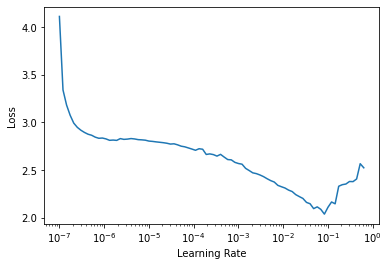

In [201]:
learn.lr_find()

In [204]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_from_embs128_v2'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,0.302651,0.380037,0.625821,01:03
1,0.281782,0.365267,0.652115,00:49
2,0.334505,0.368616,0.657149,00:38
3,0.281886,0.359624,0.660878,00:37
4,0.298152,0.367090,0.656147,00:38
5,0.297698,0.364849,0.632256,00:37
6,0.323939,0.366066,0.643253,00:39
7,0.273691,0.368048,0.645112,00:37
8,0.289223,0.371051,0.639790,00:38
9,0.271979,0.365498,0.645190,00:37


Better model found at epoch 0 with f1_score value: 0.6258206064437398.


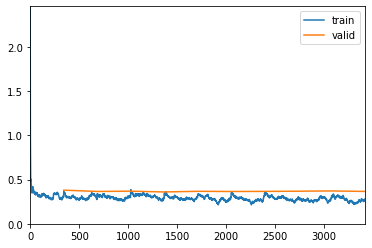

Better model found at epoch 0 with f1_score value: 0.6258206064437398.
Better model found at epoch 1 with f1_score value: 0.652114885359575.
Better model found at epoch 1 with f1_score value: 0.652114885359575.
Better model found at epoch 2 with f1_score value: 0.6571491773676691.
Better model found at epoch 2 with f1_score value: 0.6571491773676691.
Better model found at epoch 3 with f1_score value: 0.6608782772338028.
Better model found at epoch 3 with f1_score value: 0.6608782772338028.


In [206]:
learn.fit_one_cycle(10, lr_max=1e-3)

In [207]:
model = LSTMModel(7936, 12, hidden_dim=256)

In [208]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.5248074531555176)

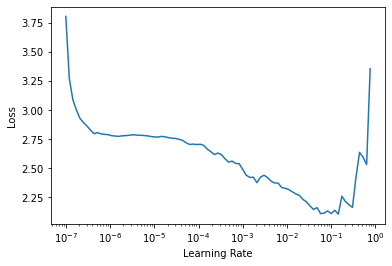

In [209]:
learn.lr_find()

In [210]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_from_embs256_v2'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,0.829625,0.411514,0.479540,00:42
1,0.406706,0.459886,0.673126,00:40
2,0.285364,0.285821,0.720272,00:38
3,0.193184,0.272489,0.732717,00:38
4,0.143771,0.247235,0.763651,00:38
5,0.123734,0.335370,0.736207,00:37
6,0.100093,0.266742,0.766696,00:38
7,0.096467,0.260147,0.767779,00:36
8,0.078322,0.243979,0.776195,00:41
9,0.065205,0.256023,0.766660,00:38


Better model found at epoch 0 with f1_score value: 0.47954033537462837.


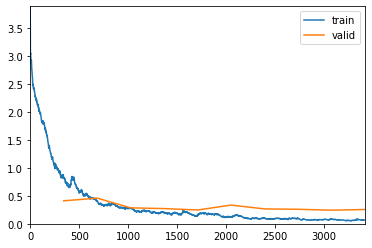

Better model found at epoch 1 with f1_score value: 0.6731259603918082.
Better model found at epoch 2 with f1_score value: 0.7202718583155322.
Better model found at epoch 3 with f1_score value: 0.7327169559053707.
Better model found at epoch 4 with f1_score value: 0.7636505521073613.
Better model found at epoch 6 with f1_score value: 0.766695587124854.
Better model found at epoch 7 with f1_score value: 0.7677790370900953.
Better model found at epoch 8 with f1_score value: 0.7761950202023061.


In [211]:
learn.fit_one_cycle(10, lr_max=1e-3)

In [20]:
model = LSTMModel(7936, 12, hidden_dim=256)

In [21]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [22]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_from_embs256_moreEpochs_v2'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,1.040630,0.634237,0.474481,01:59
1,0.511061,0.358617,0.668317,01:43
2,0.365422,0.414417,0.677517,01:44
3,0.291185,0.285304,0.702752,01:47
4,0.261520,0.275751,0.737119,01:25
5,0.172379,0.296243,0.728619,01:37
6,0.181910,0.323274,0.736656,01:47
7,0.131442,0.268305,0.781103,02:13
8,0.105444,0.340085,0.730729,02:08
9,0.111330,0.225330,0.784543,02:05


Better model found at epoch 0 with f1_score value: 0.47448061836676975.


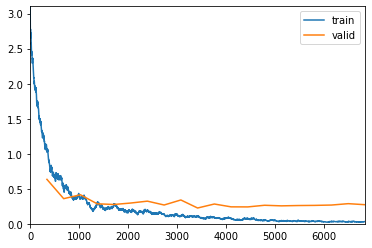

Better model found at epoch 1 with f1_score value: 0.6683166316881657.
Better model found at epoch 2 with f1_score value: 0.6775169108148926.
Better model found at epoch 3 with f1_score value: 0.7027524646356955.
Better model found at epoch 4 with f1_score value: 0.7371194905036823.
Better model found at epoch 7 with f1_score value: 0.7811033802286111.
Better model found at epoch 9 with f1_score value: 0.784543138351753.
Better model found at epoch 14 with f1_score value: 0.7930423995066297.
Better model found at epoch 17 with f1_score value: 0.7942292980489317.


In [23]:
learn.fit_one_cycle(20, lr_max=1e-3)

In [24]:
learn.load("best_sequence_from_embs256_moreEpochs_v2")

In [25]:
def evaluate(learn, dl):
    preds, targets = learn.get_preds(dl=dl)
    preds =[np.argmax(x, axis=-1) for sublist in preds for x in sublist]
    targets = [x for sublist in targets for x in sublist]
    pad_idxs = [i for i,x in enumerate(targets) if x != tensor([12])]
    preds = L(preds)[pad_idxs]
    targets = L(targets)[pad_idxs]
    print(classification_report(targets, preds, target_names=dl.get_labels.cat.vocab, digits=4))
    preds = [x % 6 for x in preds]
    targets = [x % 6 for x in targets]
    print(classification_report(targets, preds, target_names=[x[2:] for x in dl.get_labels.cat.vocab[:6]], digits=4))

In [26]:
evaluate(learn, dls.valid)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.8980    0.8756    0.8866       201
B-agravo_em_recurso_extraordinario     0.6267    0.5949    0.6104       237
     B-despacho_de_admissibilidade     0.8644    0.6939    0.7698       147
                          B-outros     0.9458    0.8973    0.9209     25898
                   B-peticao_do_RE     0.7331    0.6656    0.6977       326
                        B-sentenca     0.8123    0.7465    0.7780       284
          I-acordao_de_2_instancia     0.6632    0.6429    0.6528        98
I-agravo_em_recurso_extraordinario     0.6153    0.6349    0.6250      1912
     I-despacho_de_admissibilidade     0.5357    0.4167    0.4688        36
                          I-outros     0.9276    0.9455    0.9364     58206
                   I-peticao_do_RE     0.7596    0.8127    0.7852      6038
                        I-sentenca     0.8962    0.7855    0.8372      1352

          

In [ ]:
test_data = pd.DataFrame({"acts":X_test, "labels":y_test})

In [ ]:
test_dl = dls.test_dl(test_data, with_labels=True)

In [ ]:
torch.save(test_dl, "./data/test_dl_sequence_from_embs_v3.pth")

In [27]:
test_dl = torch.load("./data/test_dl_sequence_from_embs_v3.pth")

In [28]:
evaluate(learn, test_dl)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.9255    0.8744    0.8992       199
B-agravo_em_recurso_extraordinario     0.5805    0.5587    0.5694       213
     B-despacho_de_admissibilidade     0.7966    0.6395    0.7094       147
                          B-outros     0.9315    0.8965    0.9137     25744
                   B-peticao_do_RE     0.7681    0.6795    0.7211       312
                        B-sentenca     0.7962    0.7962    0.7962       265
          I-acordao_de_2_instancia     0.6286    0.8919    0.7374        74
I-agravo_em_recurso_extraordinario     0.6034    0.6450    0.6235      1628
     I-despacho_de_admissibilidade     0.4250    0.3333    0.3736        51
                          I-outros     0.9307    0.9472    0.9388     59664
                   I-peticao_do_RE     0.8057    0.8000    0.8028      6019
                        I-sentenca     0.8871    0.8182    0.8512      1210

          

In [29]:
class BiLSTMCRF(Module):
    def __init__(self, input_dim, out_dim, hidden_dim=128, img_emb_dim=4096, text_emb_dim=3840):
        self.img_none_emb = torch.nn.Embedding(num_embeddings=1, embedding_dim=img_emb_dim).cuda()
        self.text_none_emb = torch.nn.Embedding(num_embeddings=1, embedding_dim=text_emb_dim).cuda()
        self.index= tensor(0).cuda()
        self.lstm = torch.nn.LSTM(input_size=hidden_dim*4, hidden_size=hidden_dim,
                                  batch_first=True, bidirectional=True).cuda()
        self.bn1 = nn.BatchNorm1d(input_dim, momentum=0.01).cuda()
        self.bn2 = nn.BatchNorm1d(hidden_dim*2, momentum=0.01).cuda()
        self.drop1 = nn.Dropout().cuda()
        self.drop2 = nn.Dropout().cuda()
        self.lin1 = nn.Linear(input_dim, hidden_dim*4).cuda()
        self.lin2 = nn.Linear(hidden_dim*2, out_dim).cuda()
        self.relu = nn.ReLU().cuda()
        self.crf = CRF(num_tags=out_dim, batch_first=True).cuda()
    
    def crf_loss_func(self, out, targ):
        mask = tensor(targ.data != OUT_DIM)
        clean_targ = targ.clone()
        clean_targ[clean_targ==OUT_DIM]=0
        targ=targ.view(out.shape[:2])
        clean_targ=clean_targ.view(targ.shape)
        mask=mask.view(targ.shape)
        return -self.crf(out, clean_targ.long(), mask=mask, reduction="mean")
        
    def forward(self, img_act, text_act, img_none, text_none):
        img_act[img_none==1] = self.img_none_emb(self.index)
        text_act[text_none==1] = self.text_none_emb(self.index)
        x = torch.cat([img_act, text_act], axis=-1)
        x = x.permute(0, 2, 1)
        x = self.bn1(x)
        x = self.drop1(x)
        x = x.permute(0, 2, 1)
        x = self.lin1(x)
        x = self.relu(x)
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out_norm = self.bn2(out)
        out_drop = self.drop2(out_norm)
        out_drop = out_drop.permute(0, 2, 1)
        return self.lin2(out_drop)

In [ ]:
model = BiLSTMCRF(7936, 12)

In [30]:
def _accumulate(self, learn):
    pred = learn.pred
    targ = learn.y
    mask = tensor(targ.data != OUT_DIM)
    pred,targ, mask = to_detach(pred),to_detach(targ), to_detach(mask)
    mask=mask.view(pred.shape[:2])
    pred = learn.model.crf.decode(pred.cuda(),mask=mask.cuda())
    pred = tensor([[x for sublist in pred for x in sublist]]).view(-1)
    targ = targ[mask].view(-1)
    pred = torch.remainder(pred, 6)
    targ = torch.remainder(targ, 6)
    self.preds.append(pred)
    self.targs.append(targ)

AccumMetric.accumulate = _accumulate

def MyFScore(average='macro'):
    return skm_to_fastai(f1_score, average=average)

In [231]:
learn = Learner(dls, model, loss_func=model.crf_loss_func, metrics=[MyFScore()])

In [232]:
learn.validate()

(#2) [124.25593566894531,0.0015220089435886194]

In [233]:
learn.summary()

BiLSTMCRF (Input shape: ['8 x 4242 x 4096', '8 x 4242 x 3840', '8 x 4242', '8 x 4242'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            8                    4,096      True      
________________________________________________________________
Embedding            8                    3,840      True      
________________________________________________________________
LSTM                 ['8 x 4242 x 256',   657,408    True      
________________________________________________________________
BatchNorm1d          8 x 7936 x 4242      15,872     True      
________________________________________________________________
BatchNorm1d          8 x 256 x 4242       512        True      
________________________________________________________________
Dropout              8 x 7936 x 4242      0          False     
________________________________________________________________
Dropout              8 x 256 x 4242       0          False     
__________

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=6.309573450380412e-07)

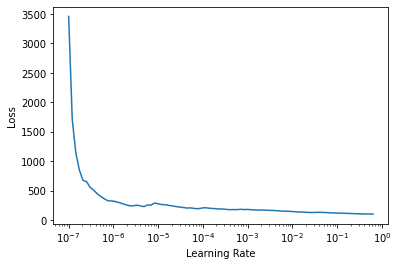

In [234]:
learn.lr_find()

In [235]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_lstm_fromEmbs_crf_128_v2'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,43.087563,38.387508,0.544540,01:53
1,18.985678,25.921474,0.728755,02:16
2,21.519173,29.197081,0.639756,02:30
3,18.487423,29.184736,0.723748,02:20
4,12.397869,20.278421,0.749210,02:20
5,12.126708,21.992531,0.759865,02:16
6,13.797823,19.913834,0.763718,02:15
7,9.811756,18.381002,0.762438,02:15
8,8.681277,16.468807,0.769699,02:15
9,9.042226,17.094530,0.771537,02:18


Better model found at epoch 0 with f1_score value: 0.5445397579622134.


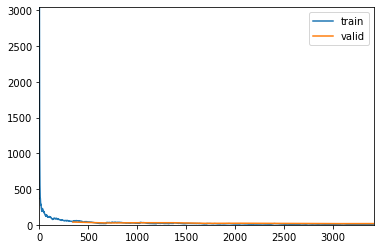

Better model found at epoch 1 with f1_score value: 0.7287551897525062.
Better model found at epoch 4 with f1_score value: 0.749209928029626.
Better model found at epoch 5 with f1_score value: 0.7598653668584308.
Better model found at epoch 6 with f1_score value: 0.7637178731461205.
Better model found at epoch 8 with f1_score value: 0.7696989643818347.
Better model found at epoch 9 with f1_score value: 0.771536726430793.


In [236]:
learn.fit_one_cycle(10, lr_max=1e-3)

In [237]:
model = BiLSTMCRF(7936, 12, hidden_dim=256)

In [238]:
learn = Learner(dls, model, loss_func=model.crf_loss_func, metrics=[MyFScore()])

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=6.309573450380412e-07)

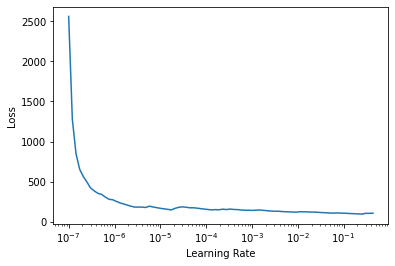

In [239]:
learn.lr_find()

In [240]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_lstm_fromEmbs_crf_256_v2'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,41.395096,38.672352,0.556004,02:05
1,21.711823,44.831909,0.703520,02:27
2,18.382008,25.725344,0.709717,02:26
3,14.044995,23.700480,0.732831,02:19
4,11.419561,20.008287,0.750565,02:20
5,11.576855,21.003958,0.734246,02:21
6,8.087695,18.342258,0.765814,02:13
7,7.809103,18.386904,0.772449,02:24
8,8.166947,14.563486,0.793292,02:30
9,6.108386,15.778090,0.783864,02:15


Better model found at epoch 0 with f1_score value: 0.5560042158290156.


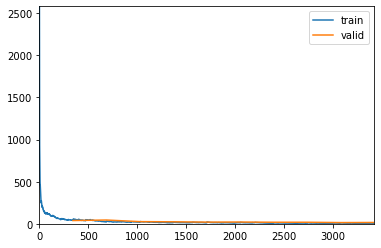

Better model found at epoch 1 with f1_score value: 0.7035202072744539.
Better model found at epoch 2 with f1_score value: 0.7097168178995231.
Better model found at epoch 3 with f1_score value: 0.7328312809693086.
Better model found at epoch 4 with f1_score value: 0.7505648710100502.
Better model found at epoch 6 with f1_score value: 0.7658144863459885.
Better model found at epoch 7 with f1_score value: 0.7724490996625765.
Better model found at epoch 8 with f1_score value: 0.7932921016271267.


In [241]:
learn.fit_one_cycle(10, lr_max=1e-3)

In [31]:
model = BiLSTMCRF(7936, 12, hidden_dim=256)

In [32]:
learn = Learner(dls, model, loss_func=model.crf_loss_func, metrics=[MyFScore()])

In [33]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_lstm_fromEmbs_crf_256_moreEpochs_v2'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,43.891697,42.756386,0.494236,02:21
1,35.473530,59.369099,0.623965,02:19
2,21.164406,30.663309,0.715249,02:18
3,15.552969,23.456547,0.714429,02:22
4,15.068018,18.081455,0.757113,02:17
5,16.581818,26.472044,0.720454,02:26
6,8.484903,19.475967,0.737480,02:20
7,11.010585,18.370821,0.757710,02:14
8,10.723814,19.689758,0.705829,02:36
9,7.120576,13.882030,0.772208,02:25


Better model found at epoch 0 with f1_score value: 0.49423554573304124.


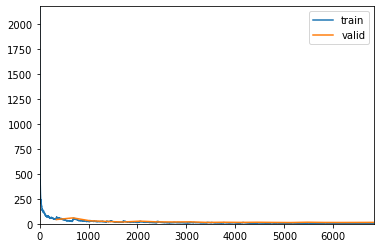

Better model found at epoch 1 with f1_score value: 0.6239652605282772.
Better model found at epoch 2 with f1_score value: 0.7152486315432364.
Better model found at epoch 4 with f1_score value: 0.7571133526381194.
Better model found at epoch 7 with f1_score value: 0.7577096686630763.
Better model found at epoch 9 with f1_score value: 0.7722082617993395.
Better model found at epoch 14 with f1_score value: 0.7743274599599387.
Better model found at epoch 17 with f1_score value: 0.776935602826985.


In [34]:
learn.fit_one_cycle(20, lr_max=1e-3)

In [35]:
learn.load("best_lstm_fromEmbs_crf_256_moreEpochs_v2")

In [36]:
def evaluate_crf(learn, dl):
    preds, targets = learn.get_preds(dl=dl)
    crf_preds =[]
    crf_targs=[]
    for pred, targ in zip(preds, targets):
        pred = pred.unsqueeze(0)
        targ = targ.unsqueeze(0)
        mask = tensor(targ.data != OUT_DIM)
        mask=mask.view(pred.shape[:2])
        pred = learn.model.crf.decode(pred.cuda(),mask=mask.cuda())
        pred = tensor([[x for sublist in pred for x in sublist]]).view(-1)
        targ = targ[mask].view(-1)
        crf_preds.append(pred)
        crf_targs.append(targ)
    crf_preds = torch.cat(crf_preds)
    crf_targs = torch.cat(crf_targs)
    print(classification_report(crf_targs, crf_preds, target_names=dls.get_labels.cat.vocab, digits=4))
    crf_preds = torch.remainder(crf_preds, 6)
    crf_targs = torch.remainder(crf_targs, 6)
    print(classification_report(crf_targs, crf_preds, target_names=dls.get_labels.cat.vocab[:6], digits=4))
    

In [37]:
evaluate_crf(learn, dls.valid)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.9323    0.8905    0.9109       201
B-agravo_em_recurso_extraordinario     0.5016    0.6709    0.5740       237
     B-despacho_de_admissibilidade     0.7761    0.7075    0.7402       147
                          B-outros     0.9571    0.8936    0.9242     25898
                   B-peticao_do_RE     0.7212    0.6902    0.7053       326
                        B-sentenca     0.8327    0.7535    0.7911       284
          I-acordao_de_2_instancia     0.7683    0.6429    0.7000        98
I-agravo_em_recurso_extraordinario     0.4642    0.7265    0.5665      1912
     I-despacho_de_admissibilidade     0.3095    0.3611    0.3333        36
                          I-outros     0.9337    0.9277    0.9307     58206
                   I-peticao_do_RE     0.6991    0.8334    0.7604      6038
                        I-sentenca     0.8858    0.7862    0.8331      1352

          

In [ ]:
test_dl = torch.load("./data/test_dl_sequence_from_embs_v3.pth")

In [38]:
evaluate_crf(learn, test_dl)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.9686    0.9296    0.9487       199
B-agravo_em_recurso_extraordinario     0.4947    0.6573    0.5645       213
     B-despacho_de_admissibilidade     0.7163    0.6871    0.7014       147
                          B-outros     0.9464    0.8928    0.9188     25744
                   B-peticao_do_RE     0.7249    0.7179    0.7214       312
                        B-sentenca     0.8030    0.8000    0.8015       265
          I-acordao_de_2_instancia     0.7391    0.9189    0.8193        74
I-agravo_em_recurso_extraordinario     0.4611    0.7537    0.5722      1628
     I-despacho_de_admissibilidade     0.3500    0.4118    0.3784        51
                          I-outros     0.9373    0.9317    0.9345     59664
                   I-peticao_do_RE     0.7274    0.8176    0.7699      6019
                        I-sentenca     0.8627    0.8306    0.8463      1210

          

In [39]:
learn.load("best_lstm_fromEmbs_crf_256_v2")